In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import Counter

# Scikit-learn imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# NLTK imports
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

# Imbalanced learning
from imblearn.combine import SMOTETomek

# Ensure NLTK resources are downloaded
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /Users/nafis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/nafis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [35]:
df = pd.read_csv('../cleaned_tweets.csv')

# drop rows where sentiment is 2 (news)
df = df[df["sentiment"] != 2]
df.reset_index(drop=True, inplace=True)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30310 entries, 0 to 30309
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   message    30310 non-null  object
 1   sentiment  30310 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 473.7+ KB


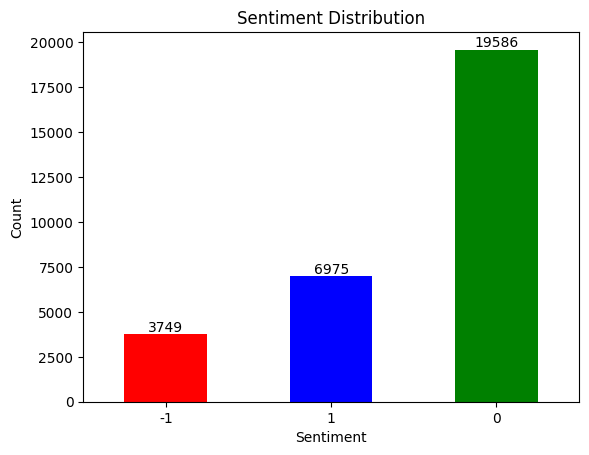

In [37]:
# Plot sentiment distribution
ax = df['sentiment'].value_counts().sort_index().plot(kind='bar', color=['red', 'blue', 'green'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=range(len(df['sentiment'].unique())), labels=df['sentiment'].unique(), rotation=0)

# Annotate the bars with exact counts
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')

plt.show()

# Data Preparation for Sentiment Analysis

Tweet texts will be transformed and vectorized to be fed into models.


In [38]:
# separate the messages column for transformation.
dfTweets = df["message"]

## Tokenization

All the tweets are first split into arrays of words.


In [39]:
def createTokenizedArray(sentences):
    """
    Create lower case array of words with no punctuation.
    :param sentences: array or series of texts
    :return: lower case array of words with no punctuation.
    """
    # Initialize tokenizer and empty array to store modified sentences.
    tokenizer = RegexpTokenizer(r"\w+")
    tokenizedArray = []
    for i in range(0, len(sentences)):
        # Convert sentence to lower case.
        sentence = sentences[i].lower()

        # Split sentence into array of words with no punctuation.
        words = tokenizer.tokenize(sentence)

        # Append word array to list.
        tokenizedArray.append(words)

    # print(tokenizedArray)
    return tokenizedArray  # send modified contents back to calling function.

In [40]:
tokenizedLi = createTokenizedArray(dfTweets)

pd.Series(tokenizedLi[:5])

0    [tiniebeany, climate, change, is, an, interest...
1    [watch, beforetheflood, right, here, as, leodi...
2    [fabulous, leonardo, dicaprio, s, film, on, cl...
3    [just, watched, this, amazing, documentary, by...
4    [leonardo, dicaprio, s, climate, change, docum...
dtype: object

## Stop Word Removal

Stop words are the words that do not add any significant values to the query search, such as "the", "a", and "an". They are safe to be removed from the tokenized list.


In [41]:
# To get stop words and wordnet for lemmatization.
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")


def removeStopWords(tokenList):
    """
    Create array of words with no punctuation or stop words.
    :param tokenList: tokenized list
    :return: array of words with no punctuation or stop words.
    """
    stopWords = set(stopwords.words("english"))
    shorterSentences = []  # Declare empty array of sentences.

    for sentence in tokenList:
        shorterSentence = []  # Declare empty array of words in single sentence.
        for word in sentence:
            if word not in stopWords:
                # Remove leading and trailing spaces.
                word = word.strip()

                # Ignore single character words and digits.
                if len(word) > 1 and word.isdigit() == False:
                    # Add remaining words to list.
                    shorterSentence.append(word)
        shorterSentences.append(shorterSentence)
    return shorterSentences

[nltk_data] Downloading package stopwords to /Users/nafis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/nafis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/nafis/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [42]:
tokenizedNoStopLi = removeStopWords(tokenizedLi)

print(f"Sample sentence BEFORE removing stop words:\n{tokenizedLi[0]}")
print(f"\n\nSample sentence AFTER removing stop words:\n{tokenizedNoStopLi[0]}")

Sample sentence BEFORE removing stop words:
['tiniebeany', 'climate', 'change', 'is', 'an', 'interesting', 'hustle', 'as', 'it', 'was', 'global', 'warming', 'but', 'the', 'planet', 'stopped', 'warming', 'for', '15', 'yes', 'while', 'the', 'suv', 'boom']


Sample sentence AFTER removing stop words:
['tiniebeany', 'climate', 'change', 'interesting', 'hustle', 'global', 'warming', 'planet', 'stopped', 'warming', 'yes', 'suv', 'boom']


## Lemmatization

English words are often time variations of a root word. Lemmatization reduces words to their base or dictionary form (lemma) by considering the context and part of speech. Unlike stemming, lemmatization produces actual words that exist in the language, which can improve the sentiment algorithm by grouping related words more accurately.


In [43]:
def lemmatizeWords(sentenceArrays):
    """
    Reduces words to their base form (lemma) and rebuilds the sentences.
    :param sentenceArrays: sentences list
    :return: array of sentences with lemmatized words
    """
    lemmatizer = WordNetLemmatizer()
    lemmatizedSentences = []
    for sentenceArray in sentenceArrays:
        lemmatizedArray = []  # Declare empty array of words.
        for word in sentenceArray:
            lemmatizedArray.append(lemmatizer.lemmatize(word))  # Add lemmatized word.

        # Convert array back to sentence of lemmatized words.
        delimeter = " "
        sentence = delimeter.join(lemmatizedArray)

        # Append lemmatized sentence to list of sentences.
        lemmatizedSentences.append(sentence)
    return lemmatizedSentences

In [44]:
lemmatizedLi = lemmatizeWords(tokenizedNoStopLi)

print(f"Sample sentence BEFORE lemmatization:\n{tokenizedNoStopLi[0]}")
print(f"\nSample sentence AFTER lemmatization:\n{lemmatizedLi[0]}")

Sample sentence BEFORE lemmatization:
['tiniebeany', 'climate', 'change', 'interesting', 'hustle', 'global', 'warming', 'planet', 'stopped', 'warming', 'yes', 'suv', 'boom']

Sample sentence AFTER lemmatization:
tiniebeany climate change interesting hustle global warming planet stopped warming yes suv boom


In [45]:
# Split train/test (stratified to keep class distribution)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    lemmatizedLi,  # use lemmatized sentences
    df['sentiment'],
    test_size=0.2,
    stratify=df['sentiment'],
    random_state=42
)

print(f"Training set size: {len(X_train_full)}")
print(f"Test set size: {len(X_test)}")
print(f"Training set sentiment distribution:\n{y_train_full.value_counts().sort_index()}")
print(f"Test set sentiment distribution:\n{y_test.value_counts().sort_index()}")

Training set size: 24248
Test set size: 6062
Training set sentiment distribution:
sentiment
-1     2999
 0     5580
 1    15669
Name: count, dtype: int64
Test set sentiment distribution:
sentiment
-1     750
 0    1395
 1    3917
Name: count, dtype: int64


In [46]:
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train_full)

print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")
print(f"Sample feature names: {list(vectorizer.vocabulary_.keys())[:10]}")

Vocabulary size: 26548
Sample feature names: ['rt', 'climate', 'change', 'pdf', '_niallmccarthy', 'ga14indivisible', 'rachelheldevans', 'think', 'accurate', 'many']


Using CountVectorizer with vocabulary size: 26548


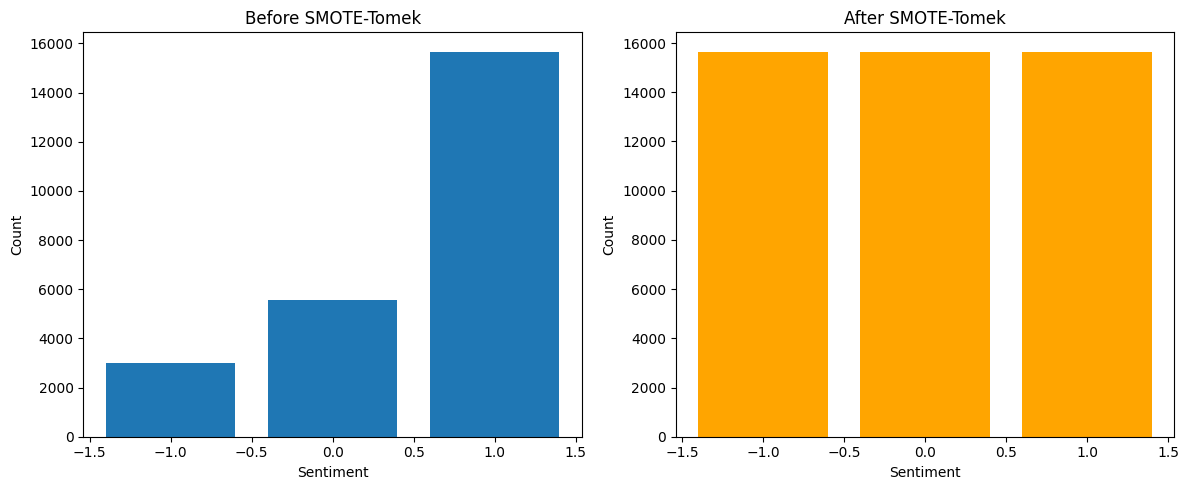

Original training set size: 24248
After SMOTE-Tomek size: 46901
Original class distribution: Counter({1: 15669, 0: 5580, -1: 2999})
After SMOTE-Tomek distribution: Counter({-1: 15654, 0: 15624, 1: 15623})


In [47]:
# Visualize class distribution before/after SMOTE-Tomek
plt.figure(figsize=(12,5))

# Original training distribution
plt.subplot(1,2,1)
plt.bar(Counter(y_train_full).keys(), Counter(y_train_full).values())
plt.title("Before SMOTE-Tomek")
plt.xlabel("Sentiment")
plt.ylabel("Count")

# Vectorize only the training data
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train_full)

# Use the CountVectorizer
print(f"Using CountVectorizer with vocabulary size: {len(vectorizer.vocabulary_)}")

# Apply SMOTE-Tomek
smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X_train_vectorized, y_train_full)

# Oversampled distribution
plt.subplot(1,2,2)
plt.bar(Counter(y_res).keys(), Counter(y_res).values(), color='orange')
plt.title("After SMOTE-Tomek")
plt.xlabel("Sentiment")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

print(f"Original training set size: {len(y_train_full)}")
print(f"After SMOTE-Tomek size: {len(y_res)}")
print(f"Original class distribution: {Counter(y_train_full)}")
print(f"After SMOTE-Tomek distribution: {Counter(y_res)}")

In [48]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),  # Only CountVectorizer for feature extraction
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

param_grid = [
    {
        'vectorizer': [CountVectorizer()],
        'vectorizer__ngram_range': [(1, 1), (1, 2)],
        'classifier': [LogisticRegression(max_iter=1000, random_state=42)],
        'classifier__C': [0.1, 1, 10]
    },
    {
        'vectorizer': [CountVectorizer()],
        'vectorizer__ngram_range': [(1, 1), (1, 2)],
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.1, 0.5, 1.0]
    },
    {
        'vectorizer': [CountVectorizer()],
        'vectorizer__ngram_range': [(1, 1), (1, 2)],
        'classifier': [RidgeClassifier(random_state=42)],
        'classifier__alpha': [0.1, 1.0, 10.0]
    },
    {
        'vectorizer': [CountVectorizer()],
        'vectorizer__ngram_range': [(1, 1), (1, 2)],
        'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20]
    }
]

In [49]:
# Run GridSearchCV with CountVectorizer and multiple classifiers
print("Starting GridSearchCV with CountVectorizer...")
print(f"Training data size: {len(X_train_full)}")

# Run GridSearchCV
start_time = time.time()

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,  # 5-fold cross-validation for faster execution
    scoring=['accuracy', 'f1_macro'],  # optimize for accuracy and f1 score
    refit='accuracy',  # refit using best accuracy score
    n_jobs=-1,  # use all available cores
    verbose=2  # show progress
)

print("Fitting GridSearchCV...")
grid.fit(X_train_full, y_train_full)

end_time = time.time()
print(f"\nGridSearchCV completed in {end_time - start_time:.2f} seconds")

# Display best results
print("\n" + "="*50)
print("BEST MODEL RESULTS")
print("="*50)
print(f"Best Model: {type(grid.best_estimator_['classifier']).__name__}")
print(f"Best Parameters: {grid.best_params_}")
print(f"Best Cross-Validation Accuracy Score: {grid.best_score_:.4f}")

# Make predictions on test set
print("\nEvaluating on test set...")
y_pred = grid.predict(X_test)

# Test set performance
test_accuracy = grid.score(X_test, y_test)
print(f"Test Set Accuracy Score: {test_accuracy:.4f}")

# Detailed classification report
print("\n" + "="*30)
print("CLASSIFICATION REPORT")
print("="*30)
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

Starting GridSearchCV with CountVectorizer...
Training data size: 24248
Fitting GridSearchCV...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END classifier=LogisticRegression(max_iter=1000, random_state=42), classifier__C=0.1, vectorizer=CountVectorizer(), vectorizer__ngram_range=(1, 1); total time=   0.7s
[CV] END classifier=LogisticRegression(max_iter=1000, random_state=42), classifier__C=0.1, vectorizer=CountVectorizer(), vectorizer__ngram_range=(1, 1); total time=   0.8s
[CV] END classifier=LogisticRegression(max_iter=1000, random_state=42), classifier__C=0.1, vectorizer=CountVectorizer(), vectorizer__ngram_range=(1, 1); total time=   0.8s
[CV] END classifier=LogisticRegression(max_iter=1000, random_state=42), classifier__C=0.1, vectorizer=CountVectorizer(), vectorizer__ngram_range=(1, 1); total time=   0.8s
[CV] END classifier=LogisticRegression(max_iter=1000, random_state=42), classifier__C=0.1, vectorizer=CountVectorizer(), vectorizer__ngram_range=(1, 1); t

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END classifier=RandomForestClassifier(random_state=42), classifier__max_depth=None, classifier__n_estimators=100, vectorizer=CountVectorizer(), vectorizer__ngram_range=(1, 2); total time= 1.1min
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__max_depth=None, classifier__n_estimators=100, vectorizer=CountVectorizer(), vectorizer__ngram_range=(1, 2); total time= 1.1min
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__max_depth=None, classifier__n_estimators=200, vectorizer=CountVectorizer(), vectorizer__ngram_range=(1, 1); total time=  46.1s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__max_depth=None, classifier__n_estimators=200, vectorizer=CountVectorizer(), vectorizer__ngram_range=(1, 1); total time=  46.1s
[CV] END classifier=RandomForestClassifier(random_state=42), classifier__max_depth=None, classifier__n_estimators=200, vectorizer=CountVectorizer(), vectorizer__ngram_range=(1, 1); total time=  46.5s


In [55]:
# Extract results from GridSearchCV
results = pd.DataFrame(grid.cv_results_)

# Select relevant columns for comparison
comparison_table = results[[
    'param_vectorizer__ngram_range',
    'param_classifier',
    'param_classifier__C',
    'param_classifier__alpha',
    'param_classifier__n_estimators',
    'param_classifier__max_depth',
    'mean_test_accuracy',
    'mean_test_f1_macro',
    'rank_test_accuracy'
]]

# Rename columns for better readability
comparison_table.rename(columns={
    'param_vectorizer__ngram_range': 'N-Gram Range',
    'param_classifier': 'Classifier',
    'param_classifier__C': 'C (Logistic Regression)',
    'param_classifier__alpha': 'Alpha (Naive Bayes/Ridge)',
    'param_classifier__n_estimators': 'N Estimators (Random Forest)',
    'param_classifier__max_depth': 'Max Depth (Random Forest)',
    'mean_test_accuracy': 'Mean Test Accuracy',
    'mean_test_f1_macro': 'Mean Test F1 Score',
    'rank_test_accuracy': 'Rank'
}, inplace=True)

# Sort by rank
comparison_table.sort_values(by='Rank', inplace=True)

# Display the table
comparison_table.reset_index(drop=True, inplace=True)
comparison_table

/var/folders/sk/y2tr30gd0rb5nh0nxms786m00000gn/T/ipykernel_38664/1549027882.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_table.rename(columns={
/var/folders/sk/y2tr30gd0rb5nh0nxms786m00000gn/T/ipykernel_38664/1549027882.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comparison_table.sort_values(by='Rank', inplace=True)


,N-Gram Range,Classifier,C (Logistic Regression),Alpha (Naive Bayes/Ridge),N Estimators (Random Forest),Max Depth (Random Forest),Mean Test Accuracy,Mean Test F1 Score,Rank
0,"(1, 2)",RidgeClassifier(random_state=42),NaN,10.0,NaN,NaN,0.744144,0.617990,1
1,"(1, 2)","LogisticRegression(max_iter=1000, random_state...",1.0,NaN,NaN,NaN,0.743278,0.627885,2
2,"(1, 2)","LogisticRegression(max_iter=1000, random_state...",10.0,NaN,NaN,NaN,0.741711,0.634247,3
3,"(1, 2)",RidgeClassifier(random_state=42),NaN,1.0,NaN,NaN,0.736349,0.623899,4
4,"(1, 2)","LogisticRegression(max_iter=1000, random_state...",0.1,NaN,NaN,NaN,0.735813,0.595255,5
5,"(1, 1)",RidgeClassifier(random_state=42),NaN,10.0,NaN,NaN,0.734535,0.601703,6
6,"(1, 1)","LogisticRegression(max_iter=1000, random_state...",1.0,NaN,NaN,NaN,0.731978,0.620819,7
7,"(1, 1)","LogisticRegression(max_iter=1000, random_state...",0.1,NaN,NaN,NaN,0.730040,0.585501,8
8,"(1, 2)",MultinomialNB(),NaN,0.5,NaN,NaN,0.728967,0.570301,9
9,"(1, 1)",MultinomialNB(),NaN,0.5,NaN,NaN,0.728637,0.599965,10


In [58]:
# Debug: Check the structure of best_models
best_models = comparison_table.head(3).copy()
print("Type of classifier in first row:", type(best_models.iloc[0]['Classifier']))
print("First classifier object:", best_models.iloc[0]['Classifier'])
print("\nAll classifiers:")
for i, classifier in enumerate(best_models['Classifier']):
    print(f"Row {i}: {type(classifier)} - {classifier}")

Type of classifier in first row: <class 'sklearn.linear_model._ridge.RidgeClassifier'>
First classifier object: RidgeClassifier(random_state=42)

All classifiers:
Row 0: <class 'sklearn.linear_model._ridge.RidgeClassifier'> - RidgeClassifier(random_state=42)
Row 1: <class 'sklearn.linear_model._logistic.LogisticRegression'> - LogisticRegression(max_iter=1000, random_state=42)
Row 2: <class 'sklearn.linear_model._logistic.LogisticRegression'> - LogisticRegression(max_iter=1000, random_state=42)


In [60]:
from sklearn.metrics import classification_report

# Get the top 3 best models from comparison_table
best_models = comparison_table.head(3).copy()

# Iterate through each best model
for _, row in best_models.iterrows():
    print("=" * 50)
    print(f"Evaluating Model: {type(row['Classifier']).__name__}")
    print("=" * 50)
    
    # Extract the best parameters for the current model
    pipeline.set_params(
        vectorizer__ngram_range=row['N-Gram Range'],
        classifier=row['Classifier']  # Use the classifier instance directly
    )
    
    # Set additional parameters based on classifier type
    if isinstance(row['Classifier'], LogisticRegression):
        pipeline.set_params(classifier__C=row['C (Logistic Regression)'])
    elif isinstance(row['Classifier'], MultinomialNB):
        pipeline.set_params(classifier__alpha=row['Alpha (Naive Bayes/Ridge)'])
    elif isinstance(row['Classifier'], RidgeClassifier):
        pipeline.set_params(classifier__alpha=row['Alpha (Naive Bayes/Ridge)'])
    elif isinstance(row['Classifier'], RandomForestClassifier):
        pipeline.set_params(
            classifier__n_estimators=int(row['N Estimators (Random Forest)']),
            classifier__max_depth=row['Max Depth (Random Forest)']
        )
    
    # Refit the pipeline with the best parameters
    pipeline.fit(X_train_full, y_train_full)
    
    # Predict on the test set
    y_pred = pipeline.predict(X_test)
    
    # Display the classification report
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

Evaluating Model: RidgeClassifier
              precision    recall  f1-score   support

    Negative       0.76      0.44      0.56       750
     Neutral       0.59      0.40      0.48      1395
    Positive       0.77      0.92      0.84      3917

    accuracy                           0.74      6062
   macro avg       0.71      0.59      0.63      6062
weighted avg       0.73      0.74      0.72      6062

Evaluating Model: LogisticRegression
              precision    recall  f1-score   support

    Negative       0.76      0.44      0.56       750
     Neutral       0.59      0.40      0.48      1395
    Positive       0.77      0.92      0.84      3917

    accuracy                           0.74      6062
   macro avg       0.71      0.59      0.63      6062
weighted avg       0.73      0.74      0.72      6062

Evaluating Model: LogisticRegression
              precision    recall  f1-score   support

    Negative       0.73      0.46      0.56       750
     Neutral       0.